In [379]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from collections import Counter
import pickle

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA


In [345]:
# !pip install category_encoders

In [366]:
df = pd.read_excel(r'deals.xlsx')

# Data Exploration

In [347]:
df.describe()

PORTFOLIO COMPANY ID  DEAL SIZE (CURR. MN)  DEAL SIZE (USD MN)  \
count          19017.000000          15334.000000        15334.000000   
mean          276146.022927             44.206791           32.330310   
std            96464.468641            683.186257          140.705245   
min            25996.000000              0.000000            0.000000   
25%           206578.000000              2.600000            2.600000   
50%           292411.000000              7.600000            7.500000   
75%           358439.000000             24.485000           23.852500   
max           423146.000000          76000.000000         6500.000000   

       COMPANY REVENUE (CURR. MN)  ENTRY REVENUE MULTIPLE  EBITDA (CURR. MN)  \
count                  181.000000              156.000000         147.000000   
mean                   617.035304              100.261090         114.079184   
std                   3163.787796              760.504578        2576.900920   
min                      0.000000                0.000000       -9351.000000   
25%                     10.000000                0.440000         -69.750000   
50%                     57.260000                1.220000         -21.500000   
75%                    200.000000                3.955000          -9.255000   
max                  40653.000000             8500.000000       24913.000000   

       ENTRY EBITDA MULTIPLE  
count             132.000000  
mean               -4.694773  
std                49.978655  
min              -464.040000  
25%                -4.655000  
50%                -1.640000  
75%                -0.630000  
max               300.000000

In [348]:
df.head()

DEAL ID  PORTFOLIO COMPANY ID          PORTFOLIO COMPANY  \
0  V241641                422955         Siren Marine, Inc.   
1  V241792                232453  Fortem Technologies, Inc.   
2  V241341                421074         Junify Corporation   
3  V241508                396814              Allonnia, LLC   
4  V241648                186582        Vyopta Incorporated   

  PORTFOLIO COMPANY COUNTRY  DEAL DATE DEAL STATUS                     STAGE  \
0                        US 2021-03-22   Completed         Unspecified Round   
1                        US 2021-03-22   Completed         Unspecified Round   
2                        US 2021-03-17   Completed                      Seed   
3                        US 2021-03-17   Completed         Unspecified Round   
4                        US 2021-03-16   Completed  Growth Capital/Expansion   

                          INVESTORS / BUYERS (FIRMS)        PRIMARY INDUSTRY  \
0  Yamaha Motor Ventures & Laboratory Silicon Valley  Ship Building & Repair   
1  Toshiba Infrastructure Systems & Solutions Cor...                Software   
2                                  Infinity Ventures                Software   
3                                   Evok Innovations       Power & Utilities   
4                           Vistara Capital Partners                Software   

  DEAL CURRENCY  ...  BOARD REPRESENTATIVES  \
0           NaN  ...                    NaN   
1           USD  ...                    NaN   
2           JPY  ...                    NaN   
3           USD  ...                    NaN   
4           USD  ...                    NaN   

                                  INDUSTRY VERTICALS INDUSTRY CLASSIFICATION  \
0                                        Mobile Apps             Industrials   
1  Drones, IoT (Internet of Things), Machine Lear...  Information Technology   
2                                        Mobile Apps  Information Technology   
3                                                NaN      Energy & Utilities   
4                                           Big Data  Information Technology   

   PORTFOLIO COMPANY STATUS  INVESTOR STATE/ COUNTY  INVESTOR CITY  \
0                    Active                      CA      Palo Alto   
1                    Active                     NaN            NaN   
2                    Active                     NaN          Tokyo   
3                    Active        British Columbia      Vancouver   
4                    Active                      BC      Vancouver   

   INVESTOR REGION PORTFOLIO COMPANY STATE/ COUNTY PORTFOLIO COMPANY CITY  \
0    North America                    Rhode Island                Newport   
1              NaN                              UT         Pleasant Grove   
2             Asia                      California                    NaN   
3    North America                              MA                 Boston   
4    North America                              TX                 Austin   

  PORTFOLIO COMPANY REGION  
0            North America  
1            North America  
2            North America  
3            North America  
4            North America  

[5 rows x 28 columns]

In [349]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19017 entries, 0 to 19016
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   DEAL ID                          19017 non-null  object        
 1   PORTFOLIO COMPANY ID             19017 non-null  int64         
 2   PORTFOLIO COMPANY                19017 non-null  object        
 3   PORTFOLIO COMPANY COUNTRY        19017 non-null  object        
 4   DEAL DATE                        19017 non-null  datetime64[ns]
 5   DEAL STATUS                      19017 non-null  object        
 6   STAGE                            19017 non-null  object        
 7   INVESTORS / BUYERS (FIRMS)       15407 non-null  object        
 8   PRIMARY INDUSTRY                 19017 non-null  object        
 9   DEAL CURRENCY                    15579 non-null  object        
 10  DEAL SIZE (CURR. MN)             15334 non-null  float64  

In [350]:
# See which columns have less than 30 unique values

col = []
for column in df:
    unique_vals = len(df[column].unique())
    if unique_vals > 30:
        print(column)
        col = np.append(col, column)

DEAL ID
PORTFOLIO COMPANY ID
PORTFOLIO COMPANY
DEAL DATE
INVESTORS / BUYERS (FIRMS)
PRIMARY INDUSTRY
DEAL SIZE (CURR. MN)
DEAL SIZE (USD MN)
INVESTOR COUNTRY
COMPANY REVENUE (CURR. MN)
ENTRY REVENUE MULTIPLE
EBITDA (CURR. MN)
ENTRY EBITDA MULTIPLE
BOUGHT FROM / SELLERS (FIRMS)
BOARD REPRESENTATIVES
INDUSTRY VERTICALS
INVESTOR STATE/ COUNTY
INVESTOR CITY
INVESTOR REGION
PORTFOLIO COMPANY STATE/ COUNTY
PORTFOLIO COMPANY CITY


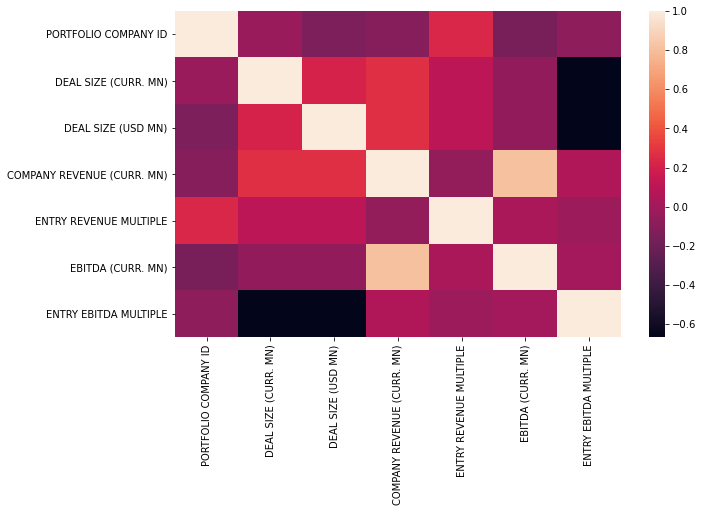

In [351]:
# See initial correlations

corrs = df.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corrs)
plt.show()

In [352]:
# Group investors

df.groupby(by=["INVESTORS / BUYERS (FIRMS)"]).mean()[["DEAL SIZE (USD MN)"]]

DEAL SIZE (USD MN)
INVESTORS / BUYERS (FIRMS)                                            
+ND Capital, Qiming Venture Partners, Clough Ca...                62.0
.406 Ventures, Accomplice, Pillar Capital                         11.0
.406 Ventures, Bain Capital Ventures, Hudson St...                10.0
.406 Ventures, Cigna Ventures, MemorialCare Inn...                24.0
.406 Ventures, Evolution Equity Partners, Arsen...                31.0
...                                                                ...
v1.vc, SK Ventures, Powerhouse Ventures, Notati...                 2.0
ward.ventures, KCRise Fund, Greycroft Partners,...                10.4
xSquared Ventures                                                  1.5
Élevage Capital Management, Catalus Capital, Ho...                22.0
Ørsted, Autotech Ventures, Energize Ventures, A...                35.0

[12760 rows x 1 columns]

In [367]:
#drop rows w/ all na values

df.dropna(axis = 0, how = 'all', inplace = True)

In [354]:
df["PRIMARY INDUSTRY"].unique()

array(['Ship Building & Repair', 'Software', 'Power & Utilities',
       'Internet', 'Biotechnology', 'Healthcare', 'Healthcare IT',
       'Business Support Services', 'Travel & Leisure',
       'Financial Services', 'Insurance', 'Consumer Services', 'Food',
       'Hardware', 'Pharmaceuticals', 'Education/Training',
       'Consumer Products', 'Semiconductors', 'IT Security/Cybersecurity',
       'Industrial Machinery', 'Chemicals', 'IT Infrastructure',
       'Outsourcing', 'Telecoms', 'Energy Storage & Batteries',
       'Commercial Property', 'Logistics & Distribution',
       'Automobiles, Other Vehicles & Parts', 'Aerospace', 'Agribusiness',
       'Retail', 'Electronics', 'Renewable Energy',
       'Transportation Services', 'Media',
       'Heating, Cooling & Ventilation Equipment and Services',
       'Environmental Services', 'Marketing/Advertising',
       'Medical Devices & Equipment', 'Information Services',
       'Construction', 'Real Estate Development & Operating Comp

In [369]:
df1["SECTOR"] = df["PRIMARY INDUSTRY"]

<ipython-input-369-03f8df1b4c50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["SECTOR"] = df["PRIMARY INDUSTRY"]


In [370]:
communication = ['Media', 'Telecoms']
cons_disc = ['Travel & Leisure', 'Consumer Services', 'Automobiles, Other Vehicles & Parts', 'Retail', 'Marketing/Advertising']
con_staples = ['Food']
energy = ['Energy Storage & Batteries', 'Renewable Energy']
financials = ['Financial Services', 'Insurance']
health = ['Biotechnology', 'Healthcare', 'Healthcare IT', 'Pharmaceuticals', 'Medical Devices & Equipment', 'Healthcare Specialists', 'Biopolymers']
industrials = ['Ship Building & Repair', 'Industrial Machinery', 'Aerospace', 'Transportation Services', 'Environmental Services', 'Construction', 'Defence', 'Rail Transport']
it = ['Software', 'IT Security/Cybersecurity', 'Internet', 'Semiconductors', 'IT Infrastructure', 'Electronics', 'Information Services']
materials = ['Chemicals', 'Agribusiness', 'Materials', 'Mining', 'Forestry & Timber', 'Packaging', 'Bottling']
realestate = ['Commercial Property', 'Real Estate Development & Operating Companies']
utilities = ['Power & Utilities', 'Heating, Cooling & Ventilation Equipment and Services']
education = ['Education/Training']

com = set(communication)

for industry in df1["SECTOR"]:
#     print(industry)
    if (industry in con_staples): 
        df1['SECTOR'] = df1['SECTOR'].replace([industry],['Consumer Staples'])
    elif (industry in cons_disc):
        df1['SECTOR'] = df1['SECTOR'].replace([industry],['Consumer Discretionary'])
    elif (industry in communication):
        df1['SECTOR'] = df1['SECTOR'].replace([industry],['Communication'])
    elif (industry in energy):
        df1['SECTOR'] = df1['SECTOR'].replace([industry],['Energy'])
    elif (industry in financials):
        df1['SECTOR'] = df1['SECTOR'].replace([industry],['Financials'])
    elif (industry in health):
        df1['SECTOR'] = df1['SECTOR'].replace([industry],['Health Care'])
    elif (industry in industrials):
        df1['SECTOR'] = df1['SECTOR'].replace([industry],['Industrials']) 
    elif (industry in it):
        df1['SECTOR'] = df1['SECTOR'].replace([industry],['Information Technology']) 
    elif (industry in materials):
        df1['SECTOR'] = df1['SECTOR'].replace([industry],['Materials']) 
    elif (industry in realestate):
        df1['SECTOR'] = df1['SECTOR'].replace([industry],['Real Estate']) 
    elif (industry in utilities):
        df1['SECTOR'] = df1['SECTOR'].replace([industry],['Utilities']) 
    elif (industry in education):
        df1['SECTOR'] = df1['SECTOR'].replace([industry],['Education']) 


<ipython-input-370-b07852df3f89>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['SECTOR'] = df1['SECTOR'].replace([industry],['Industrials'])
<ipython-input-370-b07852df3f89>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['SECTOR'] = df1['SECTOR'].replace([industry],['Information Technology'])
<ipython-input-370-b07852df3f89>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [371]:
df["SECTOR"] = df1["SECTOR"]

In [372]:
df1 = df[["INVESTORS / BUYERS (FIRMS)","DEAL SIZE (USD MN)" ]]

In [376]:
df.to_csv(r'venturedeals.csv', index = False)

In [81]:
df1 = df1.dropna()

In [82]:
df1

INVESTORS / BUYERS (FIRMS)  DEAL SIZE (USD MN)
1      Toshiba Infrastructure Systems & Solutions Cor...               15.00
2                                      Infinity Ventures                0.09
3                                       Evok Innovations               20.00
4                               Vistara Capital Partners                8.00
5      Tiger Global Management, Thrive Capital, Gron ...              200.00
...                                                  ...                 ...
19007                                        SaaStr Fund                1.80
19010   Norwest Venture Partners, Canaan Partners, Accel               26.50
19011  Compound Ventures, BluePointe Ventures, Menlo ...               12.00
19012  AME Cloud Ventures, Gates Ventures, Innovation...               16.75
19014                                         SeedInvest                3.20

[12099 rows x 2 columns]

In [374]:
df

DEAL ID  PORTFOLIO COMPANY ID                  PORTFOLIO COMPANY  \
0      V241641                422955                 Siren Marine, Inc.   
1      V241792                232453          Fortem Technologies, Inc.   
2      V241341                421074                 Junify Corporation   
3      V241508                396814                      Allonnia, LLC   
4      V241648                186582                Vyopta Incorporated   
...        ...                   ...                                ...   
19012  V145290                273459            Vicarious Surgical Inc.   
19013  V152902                287495  Uber's Southeast Asian Operations   
19014  V224691                155273                      Denim LA Inc.   
19015  V143946                270419                    StreetOne, Inc.   
19016  V224466                228898            Verdex Technology Inc.    

      PORTFOLIO COMPANY COUNTRY  DEAL DATE DEAL STATUS  \
0                            US 2021-03-22   Completed   
1                            US 2021-03-22   Completed   
2                            US 2021-03-17   Completed   
3                            US 2021-03-17   Completed   
4                            US 2021-03-16   Completed   
...                         ...        ...         ...   
19012                        US 2018-03-26   Completed   
19013                        US 2018-03-25   Completed   
19014                        US 2018-03-25   Completed   
19015                        US 2018-03-24   Completed   
19016                        US 2018-03-24   Completed   

                          STAGE  \
0             Unspecified Round   
1             Unspecified Round   
2                          Seed   
3             Unspecified Round   
4      Growth Capital/Expansion   
...                         ...   
19012          Series A/Round 1   
19013                    Add-on   
19014         Unspecified Round   
19015                      Seed   
19016              Venture Debt   

                              INVESTORS / BUYERS (FIRMS)  \
0      Yamaha Motor Ventures & Laboratory Silicon Valley   
1      Toshiba Infrastructure Systems & Solutions Cor...   
2                                      Infinity Ventures   
3                                       Evok Innovations   
4                               Vistara Capital Partners   
...                                                  ...   
19012  AME Cloud Ventures, Gates Ventures, Innovation...   
19013  Toyota Tsusho Corporation, Tiger Global Manage...   
19014                                         SeedInvest   
19015                                                NaN   
19016                                               SOSV   

              PRIMARY INDUSTRY DEAL CURRENCY  ...  \
0       Ship Building & Repair           NaN  ...   
1                     Software           USD  ...   
2                     Software           JPY  ...   
3            Power & Utilities           USD  ...   
4                     Software           USD  ...   
...                        ...           ...  ...   
19012            Healthcare IT           USD  ...   
19013  Transportation Services           NaN  ...   
19014                   Retail           USD  ...   
19015                 Internet           USD  ...   
19016                Materials           NaN  ...   

                                      INDUSTRY VERTICALS  \
0                                            Mobile Apps   
1      Drones, IoT (Internet of Things), Machine Lear...   
2                                            Mobile Apps   
3                                                    NaN   
4                                               Big Data   
...                                                  ...   
19012         HealthTech, Robotics, Virtual Reality (VR)   
19013                   E-commerce, FinTech, Mobile Apps   
19014                                   E-commerce, Paas   
19015                         

In [84]:
investor_lis = list(df1["INVESTORS / BUYERS (FIRMS)"].values)
deal_list = list(df1["DEAL SIZE (USD MN)"].values)

firm_dict = {}
for index, val in enumerate(investor_lis):
    lis = val.split(",")
    deal = deal_list[index]
    for elem in lis:
        if x not in firm_dict.keys():
            firm_dict[x] = round(deal,2)
        else:
            firm_dict[x] += round(deal,2)

In [85]:
firm_dict

{'Toshiba Infrastructure Systems & Solutions Corporation': 15.0,
 'Infinity Ventures': 0.09,
 'Evok Innovations': 20.0,
 'Vistara Capital Partners': 8.0,
 'Tiger Global Management': 7413.7,
 ' Thrive Capital': 4490.45,
 ' Gron Ventures': 250.0,
 ' Casa Verde Capital': 245.0,
 ' Dragoneer Investment Group': 13306.9,
 ' DFJ Growth': 1585.5,
 'D1 Capital Partners': 2718.0,
 ' Northpond Ventures': 751.0,
 ' Khosla Ventures': 13810.74,
 ' Think.Health Ventures': 142.25,
 ' OSF Ventures': 231.3,
 'CapitalG': 947.0,
 ' Redpoint Ventures': 5430.639999999999,
 ' New Enterprise Associates': 17167.52,
 ' Town Hall Ventures': 1373.52,
 ' Ascension Ventures': 607.1999999999999,
 ' Echo Health Ventures': 828.0,
 'Accel': 2522.4999999999995,
 ' Commerce Ventures': 519.6,
 ' Scale Venture Partners': 2768.5,
 ' Flint Capital': 190.7,
 ' Citi Ventures': 1396.7,
 ' Wells Fargo Strategic Capital': 478.1,
 ' Synchrony Ventures': 100.0,
 ' Two Sigma Investments': 2776.6200000000003,
 'Dragoneer Investment G

In [361]:
df

DEAL ID  PORTFOLIO COMPANY ID                  PORTFOLIO COMPANY  \
0      V241641                422955                 Siren Marine, Inc.   
1      V241792                232453          Fortem Technologies, Inc.   
2      V241341                421074                 Junify Corporation   
3      V241508                396814                      Allonnia, LLC   
4      V241648                186582                Vyopta Incorporated   
...        ...                   ...                                ...   
19012  V145290                273459            Vicarious Surgical Inc.   
19013  V152902                287495  Uber's Southeast Asian Operations   
19014  V224691                155273                      Denim LA Inc.   
19015  V143946                270419                    StreetOne, Inc.   
19016  V224466                228898            Verdex Technology Inc.    

      PORTFOLIO COMPANY COUNTRY  DEAL DATE DEAL STATUS  \
0                            US 2021-03-22   Completed   
1                            US 2021-03-22   Completed   
2                            US 2021-03-17   Completed   
3                            US 2021-03-17   Completed   
4                            US 2021-03-16   Completed   
...                         ...        ...         ...   
19012                        US 2018-03-26   Completed   
19013                        US 2018-03-25   Completed   
19014                        US 2018-03-25   Completed   
19015                        US 2018-03-24   Completed   
19016                        US 2018-03-24   Completed   

                          STAGE  \
0             Unspecified Round   
1             Unspecified Round   
2                          Seed   
3             Unspecified Round   
4      Growth Capital/Expansion   
...                         ...   
19012          Series A/Round 1   
19013                    Add-on   
19014         Unspecified Round   
19015                      Seed   
19016              Venture Debt   

                              INVESTORS / BUYERS (FIRMS)  \
0      Yamaha Motor Ventures & Laboratory Silicon Valley   
1      Toshiba Infrastructure Systems & Solutions Cor...   
2                                      Infinity Ventures   
3                                       Evok Innovations   
4                               Vistara Capital Partners   
...                                                  ...   
19012  AME Cloud Ventures, Gates Ventures, Innovation...   
19013  Toyota Tsusho Corporation, Tiger Global Manage...   
19014                                         SeedInvest   
19015                                                NaN   
19016                                               SOSV   

              PRIMARY INDUSTRY DEAL CURRENCY  ...  \
0       Ship Building & Repair           NaN  ...   
1                     Software           USD  ...   
2                     Software           JPY  ...   
3            Power & Utilities           USD  ...   
4                     Software           USD  ...   
...                        ...           ...  ...   
19012            Healthcare IT           USD  ...   
19013  Transportation Services           NaN  ...   
19014                   Retail           USD  ...   
19015                 Internet           USD  ...   
19016                Materials           NaN  ...   

                                      INDUSTRY VERTICALS  \
0                                            Mobile Apps   
1      Drones, IoT (Internet of Things), Machine Lear...   
2                                            Mobile Apps   
3                                                    NaN   
4                                               Big Data   
...                                                  ...   
19012         HealthTech, Robotics, Virtual Reality (VR)   
19013                   E-commerce, FinTech, Mobile Apps   
19014                                   E-commerce, Paas   
19015                         

In [86]:
# df["splitinvestors"] = df["INVESTORS / BUYERS (FIRMS)"].str.split(",")

# #make sure it's a list

# df["splitinvestors"].loc[19012][0]

In [87]:
df.columns

Index(['DEAL ID', 'PORTFOLIO COMPANY ID', 'PORTFOLIO COMPANY',
       'PORTFOLIO COMPANY COUNTRY', 'DEAL DATE', 'DEAL STATUS', 'STAGE',
       'INVESTORS / BUYERS (FIRMS)', 'PRIMARY INDUSTRY', 'DEAL CURRENCY',
       'DEAL SIZE (CURR. MN)', 'DEAL SIZE (USD MN)', 'INVESTOR COUNTRY',
       'COMPANY REVENUE (CURR. MN)', 'ENTRY REVENUE MULTIPLE',
       'EBITDA (CURR. MN)', 'ENTRY EBITDA MULTIPLE',
       'BOUGHT FROM / SELLERS (FIRMS)', 'BOARD REPRESENTATIVES',
       'INDUSTRY VERTICALS', 'INDUSTRY CLASSIFICATION',
       'PORTFOLIO COMPANY STATUS', 'INVESTOR STATE/ COUNTY', 'INVESTOR CITY',
       'INVESTOR REGION', 'PORTFOLIO COMPANY STATE/ COUNTY',
       'PORTFOLIO COMPANY CITY', 'PORTFOLIO COMPANY REGION'],
      dtype='object')

In [88]:
# #fill nans with empty lists

# for row in df.loc[df.splitinvestors.isnull(), 'splitinvestors'].index:
#     df.at[row, 'splitinvestors'] = []

In [89]:
# # loop thru splitinvestors - new list 

# firms = []
# dealsize = []
# count = 0

# for row in df["splitinvestors"]:
#     if type(row) != list: 
#         continue
#     for investor in row: 
#         firms.append(investor)
#         dealsize.append(df.loc[count, "DEAL SIZE (USD MN)"])
#     count += 1
    
# # see which ones have most count 

In [90]:
# firmdict = {firms[i]: dealsize[i] for i in range(len(firms))}

In [91]:
# #sort values in dict by most common and also show their mean to find most prolific investors
# #sort values in dict by largest mean to find most bougie investors

# freq = Counter(k for d in firmdict for k in d)
# freq_list = sorted(freq, key=freq.get)
# freq_list.reverse()
# result = sorted(firmdict, key = lambda d: freq_list.index(list(d)[0]))
# result

In [92]:
# values_per_key = {}


# #for k, v in firmdict.items():
# #    values_per_key.setdefault(k, set()).add(v)
# #counts = {k: len(v) for k, v in values_per_key.items()}

# counts = {}
# for key in firmdict.keys():
#     if key in counts.keys():
#         counts[key] += 1
#     else:
#         counts[key] = 1


# values_per_key = {}
# for k, v in firmdict.items():
#     values_per_key.setdefault(k, set()).add(v)
# counts = {k: len(v) for k, v in values_per_key.items()}
# counts

In [93]:
main_df = pd.DataFrame(firm_dict.items(), columns=['Firms','DEAL SIZE (CURR. MN)'])

In [94]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
main_df["encodedfirms"] = le.fit(main_df["Firms"]).transform(main_df["Firms"])

In [101]:
main_df

Firms  \
0      Toshiba Infrastructure Systems & Solutions Cor...   
1                                      Infinity Ventures   
2                                       Evok Innovations   
3                               Vistara Capital Partners   
4                                Tiger Global Management   
...                                                  ...   
11805                            PieLAB Venture Partners   
11806                                    Tempus Partners   
11807                                    Larsen Ventures   
11808                                      Alium Capital   
11809                                        SaaStr Fund   

       DEAL SIZE (CURR. MN)  encodedfirms  
0                     15.00         11345  
1                      0.09          9434  
2                     20.00          8837  
3                      8.00         11568  
4                   7413.70         11328  
...                     ...           ...  
11805                  0.50         10423  
11806                  0.50          6527  
11807                  0.50          3847  
11808                  0.50           366  
11809                  1.80         10783  

[11810 rows x 3 columns]

In [104]:
X = main_df[["DEAL SIZE (CURR. MN)", "encodedfirms"]]

In [105]:
X1 = main_df[["DEAL SIZE (CURR. MN)", "encodedfirms"]]

In [106]:
# Standardize data
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(X) 
  
# Normalizing the Data 
normalized_df = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 
  
# Reducing the dimensions of the data 
pca = PCA(n_components = 2) 
X = pca.fit_transform(normalized_df) 
X = pd.DataFrame(X) 
X.columns = ['P1', 'P2'] 
  
X.head(2)

P1        P2
0 -0.985121  0.084388
1 -0.975541  0.009313

In [107]:
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

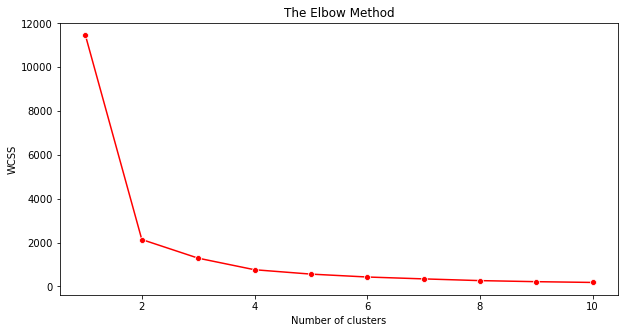

In [108]:
plt.figure(figsize=(10,5))
sns.lineplot(range(1, 11), wcss,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [109]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

In [110]:
y_kmeans

array([2, 2, 2, ..., 1, 1, 2], dtype=int32)

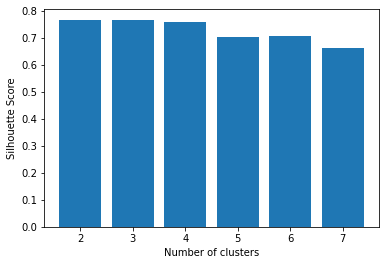

In [111]:
silhouette_scores = [] 

for n_cluster in range(2, 8):
    silhouette_scores.append( 
        silhouette_score(X, KMeans(n_clusters = n_cluster).fit_predict(X))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6,7] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

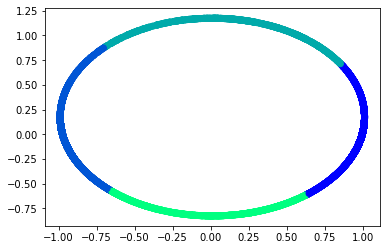

In [112]:
plt.scatter(X['P1'], X['P2'],  
           c = KMeans(n_clusters = 4).fit_predict(X), cmap =plt.cm.winter) 
plt.show() 
#PCA

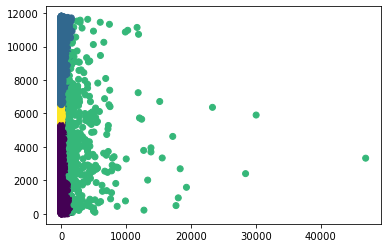

In [113]:
plt.scatter(X1['DEAL SIZE (CURR. MN)'], X1['encodedfirms'],  
           c = KMeans(n_clusters = 4).fit_predict(X)) 
plt.show() 
#PCA

In [375]:
df["PORTFOLIO COMPANY STATE/ COUNTY"].unique()

df['PORTFOLIO COMPANY STATE/ COUNTY'] = df['PORTFOLIO COMPANY STATE/ COUNTY'].replace(['Pennsylvania', 'Illinois', 'Rhode Island', 'Florida', 'Colorado', 'Texas', 'Alaska'],['PA', 'IL', 'RI', 'FL', 'CO', 'TX', 'AK'])
df['PORTFOLIO COMPANY STATE/ COUNTY'] = df['PORTFOLIO COMPANY STATE/ COUNTY'].replace(['California', 'New Jersey', 'Utah', 'Tennessee', 'Delaware', 'Massachusetts', 'Washington', 'Montana', 'Ohio', 'New York'],['CA', 'NJ', 'UT', 'TN', 'DE', 'MA', 'WA', 'MT', 'OH', 'NY'])
df['PORTFOLIO COMPANY STATE/ COUNTY'] = df['PORTFOLIO COMPANY STATE/ COUNTY'].replace(['Maryland'],['MD'])

df.loc[df["PORTFOLIO COMPANY STATE/ COUNTY"] == 'CA', 'PORTFOLIO COMPANY STATE/ COUNTY'].count()

7691

In [363]:
for x in df['PORTFOLIO COMPANY STATE/ COUNTY']:
    eachcount = df.loc[df["PORTFOLIO COMPANY STATE/ COUNTY"] == x, 'PORTFOLIO COMPANY STATE/ COUNTY'].count()
    if eachcount >= 1000:
        df['PORTFOLIO COMPANY STATE/ COUNTY'] = df['PORTFOLIO COMPANY STATE/ COUNTY'].replace([x],['Over 1000'])
    elif df.loc[df["PORTFOLIO COMPANY STATE/ COUNTY"] == x, 'PORTFOLIO COMPANY STATE/ COUNTY'].count() >= 300:
        df['PORTFOLIO COMPANY STATE/ COUNTY'] = df['PORTFOLIO COMPANY STATE/ COUNTY'].replace([x],['Over 300'])
    elif df.loc[df["PORTFOLIO COMPANY STATE/ COUNTY"] == x, 'PORTFOLIO COMPANY STATE/ COUNTY'].count() >= 100:
        df['PORTFOLIO COMPANY STATE/ COUNTY'] = df['PORTFOLIO COMPANY STATE/ COUNTY'].replace([x],['Over 100'])
    else: 
        df['PORTFOLIO COMPANY STATE/ COUNTY'] = df['PORTFOLIO COMPANY STATE/ COUNTY'].replace([x],['Less than 100'])  
        

In [364]:
df["PORTFOLIO COMPANY STATE/ COUNTY"].value_counts()

Over 1000        18707
Over 100           226
Less than 100       84
Name: PORTFOLIO COMPANY STATE/ COUNTY, dtype: int64

In [365]:
df.head()

DEAL ID  PORTFOLIO COMPANY ID          PORTFOLIO COMPANY  \
0  V241641                422955         Siren Marine, Inc.   
1  V241792                232453  Fortem Technologies, Inc.   
2  V241341                421074         Junify Corporation   
3  V241508                396814              Allonnia, LLC   
4  V241648                186582        Vyopta Incorporated   

  PORTFOLIO COMPANY COUNTRY  DEAL DATE DEAL STATUS                     STAGE  \
0                        US 2021-03-22   Completed         Unspecified Round   
1                        US 2021-03-22   Completed         Unspecified Round   
2                        US 2021-03-17   Completed                      Seed   
3                        US 2021-03-17   Completed         Unspecified Round   
4                        US 2021-03-16   Completed  Growth Capital/Expansion   

                          INVESTORS / BUYERS (FIRMS)        PRIMARY INDUSTRY  \
0  Yamaha Motor Ventures & Laboratory Silicon Valley  Ship Building & Repair   
1  Toshiba Infrastructure Systems & Solutions Cor...                Software   
2                                  Infinity Ventures                Software   
3                                   Evok Innovations       Power & Utilities   
4                           Vistara Capital Partners                Software   

  DEAL CURRENCY  ...                                 INDUSTRY VERTICALS  \
0           NaN  ...                                        Mobile Apps   
1           USD  ...  Drones, IoT (Internet of Things), Machine Lear...   
2           JPY  ...                                        Mobile Apps   
3           USD  ...                                                NaN   
4           USD  ...                                           Big Data   

   INDUSTRY CLASSIFICATION PORTFOLIO COMPANY STATUS  INVESTOR STATE/ COUNTY  \
0              Industrials                   Active                      CA   
1   Information Technology                   Active                     NaN   
2   Information Technology                   Active                     NaN   
3       Energy & Utilities                   Active        British Columbia   
4   Information Technology                   Active                      BC   

   INVESTOR CITY  INVESTOR REGION  PORTFOLIO COMPANY STATE/ COUNTY  \
0      Palo Alto    North America                        Over 1000   
1            NaN              NaN                        Over 1000   
2          Tokyo             Asia                        Over 1000   
3      Vancouver    North America                        Over 1000   
4      Vancouver    North America                        Over 1000   

  PORTFOLIO COMPANY CITY PORTFOLIO COMPANY REGION                  SECTOR  
0                Newport            North America             Industrials  
1         Pleasant Grove            North America  Information Technology  
2                    NaN            North America  Information Technology  
3                 Boston            North America               Utilities  
4                 Austin            North America  Information Technology  

[5 rows x 29 columns]

# Encoding

In [123]:
encoder=ce.OneHotEncoder(cols=['DEAL STATUS', 'PORTFOLIO COMPANY STATE/ COUNTY'],handle_unknown='return_nan',return_df=True,use_cat_names=True)


In [148]:
data_encoded = encoder.fit_transform(df)
data_encoded["DEAL SIZE (CURR. MN)"] = df["DEAL SIZE (CURR. MN)"]
data_encoded["encodedfirms"] = df["encodedfirms"]
data_encoded.head()

DEAL ID  PORTFOLIO COMPANY ID          PORTFOLIO COMPANY  \
0  V241641                422955         Siren Marine, Inc.   
1  V241792                232453  Fortem Technologies, Inc.   
2  V241341                421074         Junify Corporation   
3  V241508                396814              Allonnia, LLC   
4  V241648                186582        Vyopta Incorporated   

  PORTFOLIO COMPANY COUNTRY  DEAL DATE  DEAL STATUS_Completed  \
0                        US 2021-03-22                    1.0   
1                        US 2021-03-22                    1.0   
2                        US 2021-03-17                    1.0   
3                        US 2021-03-17                    1.0   
4                        US 2021-03-16                    1.0   

   DEAL STATUS_Bidding  DEAL STATUS_Announced  DEAL STATUS_Rejected  \
0                  0.0                    0.0                   0.0   
1                  0.0                    0.0                   0.0   
2                  0.0                    0.0                   0.0   
3                  0.0                    0.0                   0.0   
4                  0.0                    0.0                   0.0   

   DEAL STATUS_Abandoned  ... PORTFOLIO COMPANY STATUS INVESTOR STATE/ COUNTY  \
0                    0.0  ...                   Active                     CA   
1                    0.0  ...                   Active                    NaN   
2                    0.0  ...                   Active                    NaN   
3                    0.0  ...                   Active       British Columbia   
4                    0.0  ...                   Active                     BC   

  INVESTOR CITY INVESTOR REGION  PORTFOLIO COMPANY STATE/ COUNTY_Over 1000  \
0     Palo Alto   North America                                        1.0   
1           NaN             NaN                                        1.0   
2         Tokyo            Asia                                        1.0   
3     Vancouver   North America                                        1.0   
4     Vancouver   North America                                        1.0   

   PORTFOLIO COMPANY STATE/ COUNTY_Over 100  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

  PORTFOLIO COMPANY STATE/ COUNTY_Less than 100  PORTFOLIO COMPANY CITY  \
0                                           0.0                 Newport   
1                                           0.0          Pleasant Grove   
2                                           0.0                     NaN   
3                                           0.0                  Boston   
4                                           0.0                  Austin   

   PORTFOLIO COMPANY REGION  encodedfirms  
0             North America       11345.0  
1             North America        9434.0  
2             North America        8837.0  
3             North America       11568.0  
4             North America       11328.0  

[5 rows x 35 columns]

In [157]:
# col = []
# for column in data_encoded:
#     for i in column: 
#         print(i)
#         if type(i) == str and column not in col:
#             print(column)
#             col.append(column)

col = []
for column in data_encoded:
    for i in data_encoded[column]:
        if type(i) == str:
            print(column)
            if column not in col:
                col.append(column)
col


DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID


DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID


DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID


DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID


DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID


DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID


DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID


DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID


DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID


DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID


DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID


DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID
DEAL ID


PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO 

PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO 

PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO 

PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO 

PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO 

PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO 

PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO 

PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO 

PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO 

PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO 

PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO COMPANY
PORTFOLIO 

PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO CO

PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO CO

PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO CO

PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO CO

PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO CO

PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO CO

PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO CO

PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO CO

PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO CO

PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO CO

PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO CO

PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO COMPANY COUNTRY
PORTFOLIO CO

STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAG

STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAG

STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAG

STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAG

STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAG

STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAG

STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAGE
STAG

INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
I

INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
I

INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
I

INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
I

INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
I

INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
I

INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
I

INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
I

INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
INVESTORS / BUYERS (FIRMS)
I

PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUST

PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUST

PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUST

PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUST

PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUST

PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUST

PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUST

PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUST

PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUST

PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUSTRY
PRIMARY INDUST

DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL C

DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL C

DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL C

DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL C

DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL C

DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL C

DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL CURRENCY
DEAL C

INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNT

INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNT

INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNT

INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNT

INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNT

INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNT

INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNT

INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNT

INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNT

INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNTRY
INVESTOR COUNT

BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPRESENTATIVES
BOARD REPR

INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VER

INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VER

INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VER

INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VER

INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VER

INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VER

INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VER

INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VER

INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VERTICALS
INDUSTRY VER

INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIF

INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIF

INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIF

INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIF

INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIF

INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIF

INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIF

INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIF

INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIF

INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIFICATION
INDUSTRY CLASSIF

PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS


PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS


PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS


PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS


PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS


PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS


PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS


PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS


PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS


PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS


PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS
PORTFOLIO COMPANY STATUS


INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR ST

INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR ST

INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR ST

INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR ST

INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR ST

INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR ST

INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR STATE/ COUNTY
INVESTOR ST

INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVEST

INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVEST

INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVEST

INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVEST

INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVESTOR CITY
INVEST

INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR

INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR

INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR

INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR

INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR REGION
INVESTOR

PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO C

PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO C

PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO C

PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO C

PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO C

PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO C

PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO C

PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO C

PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO C

PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO COMPANY CITY
PORTFOLIO C

PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION


PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION


PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION


PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION


PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION


PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION


PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION


PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION


PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION


PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION


PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION
PORTFOLIO COMPANY REGION


['DEAL ID',
 'PORTFOLIO COMPANY',
 'PORTFOLIO COMPANY COUNTRY',
 'STAGE',
 'INVESTORS / BUYERS (FIRMS)',
 'PRIMARY INDUSTRY',
 'DEAL CURRENCY',
 'INVESTOR COUNTRY',
 'BOUGHT FROM / SELLERS (FIRMS)',
 'BOARD REPRESENTATIVES',
 'INDUSTRY VERTICALS',
 'INDUSTRY CLASSIFICATION',
 'PORTFOLIO COMPANY STATUS',
 'INVESTOR STATE/ COUNTY',
 'INVESTOR CITY',
 'INVESTOR REGION',
 'PORTFOLIO COMPANY CITY',
 'PORTFOLIO COMPANY REGION']

In [173]:
feat = data_encoded.drop(col, axis = 1)
feat = feat.drop(["DEAL DATE"], axis = 1)
feat["deal size"] = df["DEAL SIZE (CURR. MN)"]
feat = feat.fillna(0)

feat.head()

PORTFOLIO COMPANY ID  DEAL STATUS_Completed  DEAL STATUS_Bidding  \
0                422955                    1.0                  0.0   
1                232453                    1.0                  0.0   
2                421074                    1.0                  0.0   
3                396814                    1.0                  0.0   
4                186582                    1.0                  0.0   

   DEAL STATUS_Announced  DEAL STATUS_Rejected  DEAL STATUS_Abandoned  \
0                    0.0                   0.0                    0.0   
1                    0.0                   0.0                    0.0   
2                    0.0                   0.0                    0.0   
3                    0.0                   0.0                    0.0   
4                    0.0                   0.0                    0.0   

   DEAL SIZE (CURR. MN)  DEAL SIZE (USD MN)  COMPANY REVENUE (CURR. MN)  \
0                   0.0                0.00                         0.0   
1                  15.0               15.00                         0.0   
2                  10.0                0.09                         0.0   
3                  20.0               20.00                         0.0   
4                   8.0                8.00                         0.0   

   ENTRY REVENUE MULTIPLE  EBITDA (CURR. MN)  ENTRY EBITDA MULTIPLE  \
0                     0.0                0.0                    0.0   
1                     0.0                0.0                    0.0   
2                     0.0                0.0                    0.0   
3                     0.0                0.0                    0.0   
4                     0.0                0.0                    0.0   

   PORTFOLIO COMPANY STATE/ COUNTY_Over 1000  \
0                                        1.0   
1                                        1.0   
2                                        1.0   
3                                        1.0   
4                                        1.0   

   PORTFOLIO COMPANY STATE/ COUNTY_Over 100  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   PORTFOLIO COMPANY STATE/ COUNTY_Less than 100  encodedfirms  deal size  
0                                            0.0       11345.0        0.0  
1                                            0.0        9434.0       15.0  
2                                            0.0        8837.0       10.0  
3                                            0.0       11568.0       20.0  
4                                            0.0       11328.0        8.0

In [241]:
features = feat.drop(["deal size", "encodedfirms", 'PORTFOLIO COMPANY ID', 'DEAL SIZE (CURR. MN)'], axis = 1)

In [244]:
dealreject = feat[['deal size', 'DEAL STATUS_Rejected']] 

# for column in rejected:
#     for x in rejected['deal size']:
#         if x == True:
        
# else: 
#     print("no")

# dealreject[dealreject['DEAL STATUS_Rejected'] == 1]


deal size
DEAL STATUS_Rejected


In [378]:
features.columns

Index(['DEAL STATUS_Completed', 'DEAL STATUS_Bidding', 'DEAL STATUS_Announced',
       'DEAL STATUS_Rejected', 'DEAL STATUS_Abandoned', 'DEAL SIZE (USD MN)',
       'COMPANY REVENUE (CURR. MN)', 'ENTRY REVENUE MULTIPLE',
       'EBITDA (CURR. MN)', 'ENTRY EBITDA MULTIPLE',
       'PORTFOLIO COMPANY STATE/ COUNTY_Over 1000',
       'PORTFOLIO COMPANY STATE/ COUNTY_Over 100',
       'PORTFOLIO COMPANY STATE/ COUNTY_Less than 100'],
      dtype='object')

# Machine Learning 

In [175]:
 # get pandas columns for prediction
target = feat["DEAL SIZE (CURR. MN)"]
features = features

# convert to lists/arrays (MUST HAPPEN)
X = np.array(features)
y = np.array(target) 

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 


In [177]:
reg = LinearRegression()
reg.fit(X_train, y_train)
print(reg.coef_)
print(reg.intercept_)

[-3.58789911e-18 -2.05330969e-13  8.17998481e-12 -4.45974223e-12
  0.00000000e+00 -3.51514820e-12  1.00000000e+00  1.51440643e-15
  7.94779885e-18  3.89724343e-18 -2.86583762e-17  2.84660542e-16
  7.96323562e-15 -2.59451014e-15 -5.36874387e-15  6.11543385e-16]
-9.592326932761353e-13


In [178]:
in_sample_preds = reg.predict(X_train)
out_sample_preds = reg.predict(X_test)

In [179]:
print("In-Sample R2: ", r2_score(y_train, in_sample_preds))
print("Out-Sample R2: ", r2_score(y_test, out_sample_preds))
print()
print("In-Sample MSE: ", mean_squared_error(y_train, in_sample_preds))
print("Out-Sample MSE: ", mean_squared_error(y_test, out_sample_preds))
print()
print("In-Sample MAE: ", mean_absolute_error(y_train, in_sample_preds))
print("Out-Sample MAE: ", mean_absolute_error(y_test, out_sample_preds))

In-Sample R2:  1.0
Out-Sample R2:  1.0

In-Sample MSE:  7.88339944389333e-24
Out-Sample MSE:  6.0057585044570315e-24

In-Sample MAE:  2.0999649124687047e-12
Out-Sample MAE:  2.0984974181252197e-12


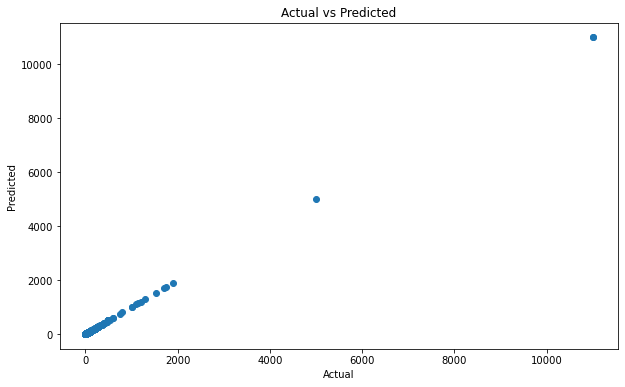

In [180]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, out_sample_preds)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
k
plt.show()

In [380]:
filename = 'finalized_model.sav'
pickle.dump(reg, open(filename, 'wb'))